In [1]:
!pip install umap-learn

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [2]:
!pip list

Package                Version
---------------------- -----------------------
absl-py                0.10.0
argon2-cffi            20.1.0
astor                  0.8.1
astunparse             1.6.3
attrs                  20.1.0
backcall               0.2.0
bleach                 3.1.5
cachetools             4.1.1
certifi                2020.6.20
cffi                   1.14.2
chainer                7.7.0
chardet                3.0.4
click                  7.1.2
cloudpickle            1.3.0
cntk-gpu               2.7
cupy                   7.8.0
cycler                 0.10.0
Cython                 0.29.21
decorator              4.4.2
defusedxml             0.6.0
dm-sonnet              2.0.0
dm-tree                0.1.5
entrypoints            0.3
enum34                 1.1.10
fastrlock              0.5
filelock               3.0.12
funcsigs               1.0.2
future                 0.18.2
gast                   0.3.3
google-auth            1.21.0
google-auth-oauthlib   0.4.1
google-pasta  

In [3]:
import sys
import os
import numpy as np
import yaml as yl
import matplotlib.pyplot as plt
import argparse
import glob
import pandas as pd
import time

from typing import List, Tuple
from functools import partial

from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [4]:
def get_model(model_name: str, **kwargs):
    LLE = partial(manifold.LocallyLinearEmbedding)
    model_name = model_name.lower()
    if model_name == 'pca':
        return PCA(**kwargs)
    elif model_name == "umap":
        return UMAP(**kwargs)
    elif model_name == "lle":
        return LLE(method='standard', **kwargs)
    elif model_name =="ltsa":
        return LLE(method='ltsa', **kwargs) 
    elif model_name == "hlle":
        return LLE(method='hessian', **kwargs)
    elif model_name == "mlle":
        return LLE(method='modified', **kwargs)
    elif model_name== "isomap":
        return manifold.Isomap(**kwargs)
    elif model_name == "mds":
        return manifold.MDS(**kwargs)
    elif model_name == "se":
        return manifold.SpectralEmbedding(**kwargs)
    elif model_name == "t-sne":
        return manifold.TSNE(**kwargs)
    raise ValueError(f"Invalid method {model_name}")

In [5]:
def perform_manifold(model, data: np.ndarray, targets: np.ndarray, n_components: int=2, scale: bool=True) -> pd.DataFrame:
    # Scale
    if scale:
        data = StandardScaler().fit_transform(data)
    
    # Apply model on data
    start = time.time()
    x = model.fit_transform(data)
    print(f"Perform manifold took {time.time()-start:.3f} seconds!")
    # TODO adapt to 3-d outputs
    principal_df = pd.DataFrame(data=x, columns=[f"PC-{i+1}" for i in range(n_components)])
    # Append targets values
    principal_df = pd.concat([principal_df, targets], axis=1)
    
    return principal_df

In [6]:
def plot_components(df: pd.DataFrame, n_classes: int, title: str, n_components: int=2, output_file: str = None, text: bool = False) -> None:
    # Create figure
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1)

    # Set colors
    colors = np.array([
        "red","green","blue","yellow","pink","black","orange","purple",
        "beige","brown","gray","cyan","magenta"])[:n_classes]
    markers = np.array([
        ".", "o", "v", "<", ">", "P", "D", "1", "4", "*", "p", "d", "s"
    ])
    # Name the targets
    targets = [i for i in range(n_classes)]
    # Plot a scatter plot 
    for target, marker, color in zip(targets, markers, colors):
        indicesToKeep = df["class"] == target
        if n_components == 2:
            ax.scatter(df.loc[indicesToKeep, 'PC-1'], df.loc[indicesToKeep, 'PC-2'], c=color, marker=marker, s=50)
        else:
            ax.scatter(df.loc[indicesToKeep, 'PC-1'], df.loc[indicesToKeep, 'PC-2'], df.loc[indicesToKeep, 'PC-3'], c=color, marker=marker, s=50)
            
    if text:
        ax.set_xlabel('X', fontsize=15)
        ax.set_ylabel('Y', fontsize=15)
        if n_components == 3:
            ax.set_ylabel('Z', fontsize=15)
        ax.set_title(title, fontsize=14)
        ax.legend(targets)
        
    ax.grid()    
    if output_file is not None:
        plt.savefig(output_file, bbox_inches='tight')
        print(f"Figure saved to {output_file}")
        
    plt.show()

In [7]:
def perform_experiment_generic(model, df: pd.DataFrame, title: str, n_components: int=2, output_file: str = None):
    features = [str(i) for i in range(65)]
    x = df.loc[:, features].values
    y = df.loc[:, ['class']]  
    principal_df = perform_manifold(model, data=x, targets=y)
    
    # Plot it
    c_min, c_max = int(y.min()), int(y.max())
    plot_components(principal_df, c_max+1, title=title, n_components=n_components, output_file=output_file)
    return principal_df, model

In [8]:
def perform_experiment_pca(df: pd.DataFrame, title: str, n_components: int=2, random_state: int=0, output_file: str = None):
    model = get_model("pca", n_components=n_components, random_state=random_state)
    return perform_experiment_generic(model=model, df=df, title=title, n_components=n_components, output_file=output_file)

def perform_experiment_tsne(df: pd.DataFrame, title: str, n_components: int=2, init: str='pca', random_state: int=0, output_file: str = None):
    model = get_model("t-sne", n_components=n_components, init=init, random_state=random_state)
    return perform_experiment_generic(model=model, df=df, title=title, n_components=n_components, output_file=output_file)

def perform_experiment_lle(df: pd.DataFrame, title: str, n_neighbors: int = 5, n_components: int=2, random_state: int=0, output_file: str = None):
    model = get_model("lle", n_components=n_components, n_neighbors=n_neighbors, random_state=random_state)
    return perform_experiment_generic(model=model, df=df, title=title, n_components=n_components, output_file=output_file)

def perform_experiment_ltsa(df: pd.DataFrame, title: str, n_neighbors: int = 5, n_components: int=2, random_state: int=0, output_file: str = None):
    model = get_model("ltsa", n_components=n_components, n_neighbors=n_neighbors, random_state=random_state)
    return perform_experiment_generic(model=model, df=df, title=title, n_components=n_components, output_file=output_file)

def perform_experiment_hlle(df: pd.DataFrame, title: str, n_neighbors: int = 5, n_components: int=2, random_state: int=0, output_file: str = None):
    model = get_model("hlle", n_components=n_components, n_neighbors=n_neighbors, random_state=random_state)
    return perform_experiment_generic(model=model, df=df, title=title, n_components=n_components, output_file=output_file)

def perform_experiment_mlle(df: pd.DataFrame, title: str, n_neighbors: int = 5, n_components: int=2, random_state: int=0, output_file: str = None):
    model = get_model("mlle", n_components=n_components, n_neighbors=n_neighbors, random_state=random_state)
    return perform_experiment_generic(model=model, df=df, title=title, n_components=n_components, output_file=output_file)

def perform_experiment_isomap(df: pd.DataFrame, title: str, n_neighbors: int = 5, n_components: int=2, output_file: str = None):
    model = get_model("isomap", n_components=n_components, n_neighbors=n_neighbors)
    return perform_experiment_generic(model=model, df=df, title=title, n_components=n_components, output_file=output_file)

def perform_experiment_se(df: pd.DataFrame, title: str, n_neighbors: int = 5, n_components: int=2, random_state: int=0, output_file: str = None):
    model = get_model("se", n_components=n_components, n_neighbors=n_neighbors, random_state=random_state)
    return perform_experiment_generic(model=model, df=df, title=title, n_components=n_components, output_file=output_file)

def perform_experiment_mds(df: pd.DataFrame, title: str, max_iter: int = 300, n_init: int=4, n_components: int=2, random_state: int=0, output_file: str = None):
    model = get_model("mds", n_components=n_components, max_iter=max_iter, n_init=n_init, random_state=random_state)
    return perform_experiment_generic(model=model, df=df, title=title, n_components=n_components, output_file=output_file)

## AnghaBestSeqsSBLP2021

In [9]:
filename = "data/AnghaBestSeqsSBLP2021.csv"
df = pd.read_csv(filename)
df.tail()

Unnamed: 0                                        name  class    0  \
2495        2495      extr_libipw_wx.c_libipw_translate_scan      2  1.0   
2496        2496                  extr_render.c_test_formats      2  1.0   
2497        2497               extr_c-valprint.c_c_val_print      2  1.0   
2498        2498             extr_sor.c_tegra_sor_edp_enable      2  1.0   
2499        2499  extr_hns_roce_hw_v2.c_hns_roce_v2_query_qp      2  1.0   

          1    2    3    4    5    6  ...    55   56    57   58   59     60  \
2495   52.0  0.0  0.0  0.0  0.0  0.0  ...  21.0  0.0   0.0  0.0  0.0   37.0   
2496   61.0  0.0  0.0  0.0  0.0  0.0  ...  51.0  0.0  15.0  2.0  0.0   22.0   
2497  153.0  1.0  0.0  0.0  0.0  0.0  ...  63.0  0.0   4.0  0.0  0.0  135.0   
2498   63.0  0.0  0.0  0.0  0.0  0.0  ...  25.0  0.0   0.0  0.0  0.0  110.0   
2499   16.0  0.0  0.0  0.0  0.0  0.0  ...   7.0  0.0   0.0  0.0  0.0   34.0   

       61   62   63   64  
2495  0.0  0.0  0.0  0.0  
2496  0.0  0.0  0.0  0.0  
2497  0.0  0.0  0.0  0.0  
2498  0.0  0.0  0.0  0.0  
2499  0.0  0.0  0.0  0.0  

[5 rows x 68 columns]

Perform manifold took 0.007 seconds!
Figure saved to outputs/AnghaBestSeqsSBLP2021.pca.default-params.pdf


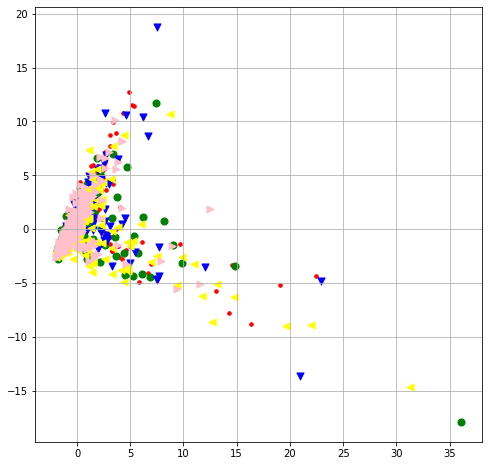

Perform manifold took 6.779 seconds!
Figure saved to outputs/AnghaBestSeqsSBLP2021.t-sne.default-params.pdf


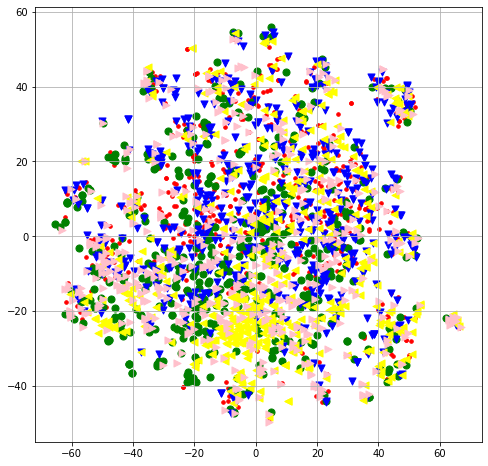

Perform manifold took 2.305 seconds!
Figure saved to outputs/AnghaBestSeqsSBLP2021.lle.default-params.pdf


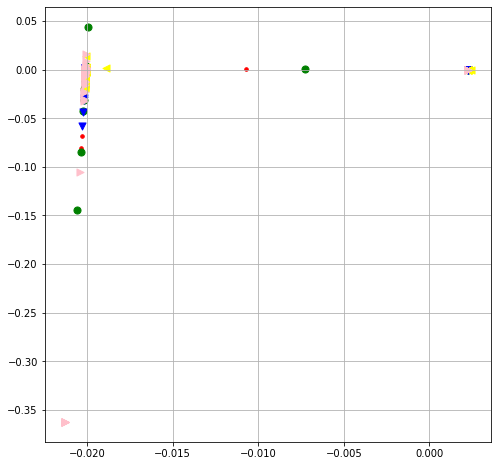

Perform manifold took 2.557 seconds!
Figure saved to outputs/AnghaBestSeqsSBLP2021.mlle.default-params.pdf


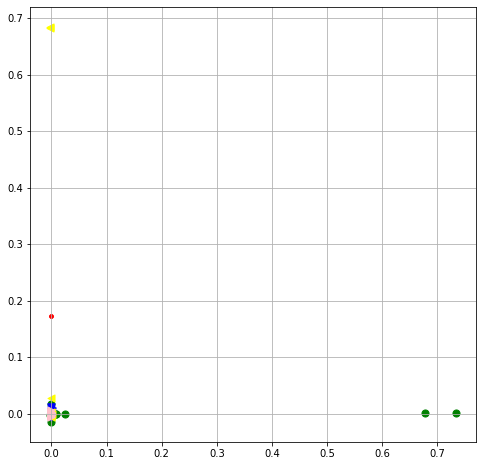

Perform manifold took 1.901 seconds!
Figure saved to outputs/AnghaBestSeqsSBLP2021.se.default-params.pdf


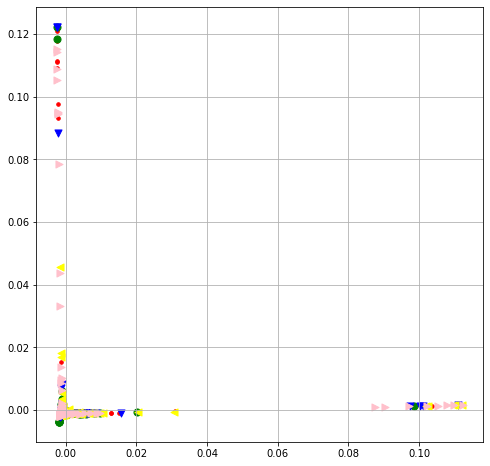

Perform manifold took 3.179 seconds!
Figure saved to outputs/AnghaBestSeqsSBLP2021.isomap.default-params.pdf


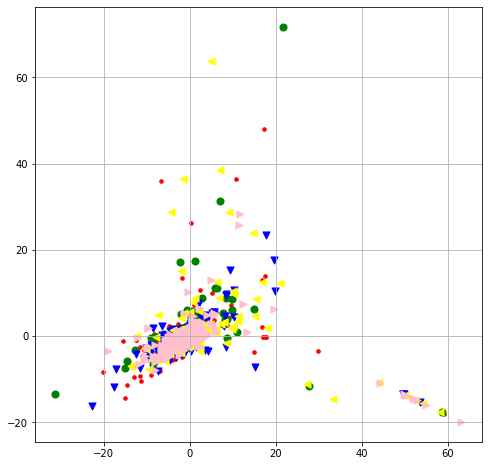

Perform manifold took 143.832 seconds!
Figure saved to outputs/AnghaBestSeqsSBLP2021.mds.default-params.pdf


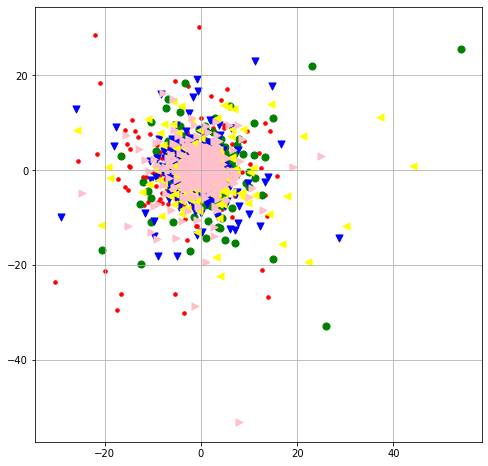

In [10]:
name = os.path.splitext(filename.split(os.sep)[-1])[0]
principal_df, model = perform_experiment_pca(df, title=f"{name} PCA", n_components=2, output_file=f'outputs/{name}.pca.default-params.pdf')
principal_df, model = perform_experiment_tsne(df, title=f"{name} T-SNE", n_components=2, output_file=f'outputs/{name}.t-sne.default-params.pdf')
principal_df, model = perform_experiment_lle(df, title=f"{name} LLE", n_components=2, output_file=f'outputs/{name}.lle.default-params.pdf')
principal_df, model = perform_experiment_mlle(df, title=f"{name} Modified LLE", n_components=2, output_file=f'outputs/{name}.mlle.default-params.pdf')
principal_df, model = perform_experiment_se(df, title=f"{name} Spectral Embeeding", n_components=2, output_file=f'outputs/{name}.se.default-params.pdf')
principal_df, model = perform_experiment_isomap(df, f"{name} ISOMAP", n_components=2, output_file=f'outputs/{name}.isomap.default-params.pdf')
principal_df, model = perform_experiment_mds(df, f"{name} MDS", n_components=2, output_file=f'outputs/{name}.mds.default-params.pdf')

## AnghaLoops

In [11]:
filename = "data/AnghaLoops.csv"
df = pd.read_csv(filename)
df.tail()

Unnamed: 0                                               name  class  \
7077        7077               extr_.hashcatsrchashcat.c_outer_loop      6   
7078        7078   extr_.linuxdrivershwmonit87.c_it87_update_device      6   
7079        7079  extr_.linuxdriversscsilpfclpfc_sli.c_lpfc_sli4...      6   
7080        7080  extr_.FFmpeglibavcodecmlpdec.c_read_decoding_p...      6   
7081        7081  extr_.linuxfsreiserfsjournal.c_journal_read_tr...      6   

        0      1    2    3    4    5    6  ...    55   56   57   58   59  \
7077  1.0  122.0  0.0  0.0  0.0  0.0  0.0  ...  61.0  0.0  0.0  0.0  0.0   
7078  1.0   44.0  0.0  0.0  0.0  0.0  0.0  ...  21.0  0.0  0.0  1.0  0.0   
7079  1.0   76.0  0.0  0.0  0.0  0.0  0.0  ...  37.0  0.0  0.0  0.0  0.0   
7080  1.0   58.0  0.0  0.0  0.0  0.0  0.0  ...  26.0  0.0  0.0  0.0  0.0   
7081  1.0   46.0  0.0  0.0  0.0  0.0  0.0  ...  18.0  0.0  0.0  0.0  0.0   

         60   61   62   63   64  
7077   74.0  0.0  0.0  0.0  0.0  
7078   40.0  0.0  0.0  0.0  0.0  
7079   50.0  0.0  0.0  0.0  0.0  
7080   17.0  0.0  0.0  0.0  0.0  
7081  101.0  0.0  0.0  0.0  0.0  

[5 rows x 68 columns]

Perform manifold took 0.021 seconds!
Figure saved to outputs/AnghaLoops.pca.default-params.pdf


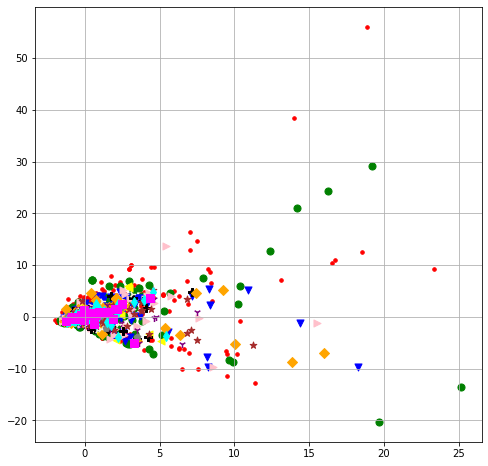

Perform manifold took 22.881 seconds!
Figure saved to outputs/AnghaLoops.t-sne.default-params.pdf


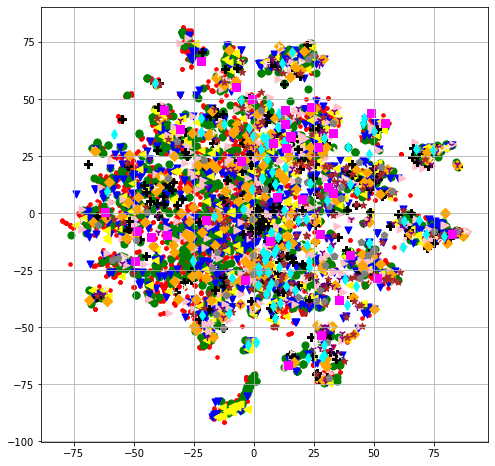

Perform manifold took 28.809 seconds!
Figure saved to outputs/AnghaLoops.lle.default-params.pdf


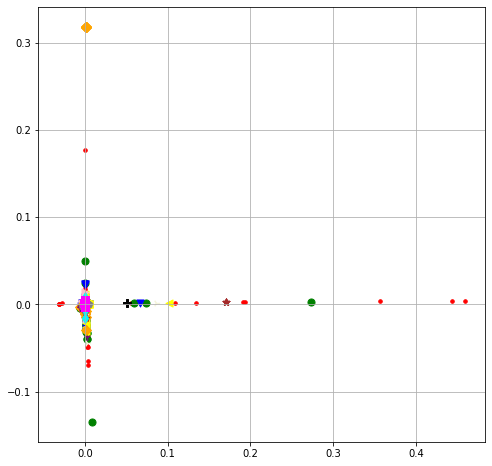

Perform manifold took 29.487 seconds!
Figure saved to outputs/AnghaLoops.mlle.default-params.pdf


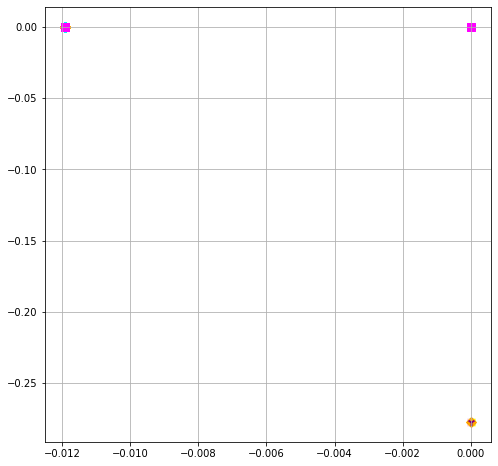

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Perform manifold took 23.020 seconds!
Figure saved to outputs/AnghaLoops.se.default-params.pdf


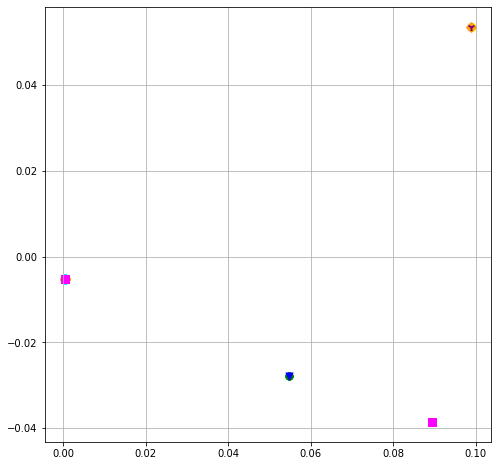

Perform manifold took 29.451 seconds!
Figure saved to outputs/AnghaLoops.isomap.default-params.pdf


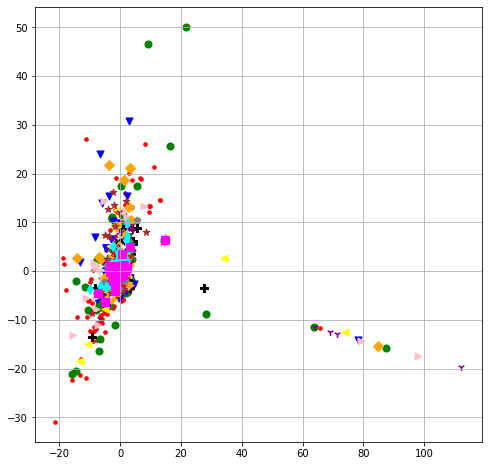

Perform manifold took 897.201 seconds!
Figure saved to outputs/AnghaLoops.mds.default-params.pdf


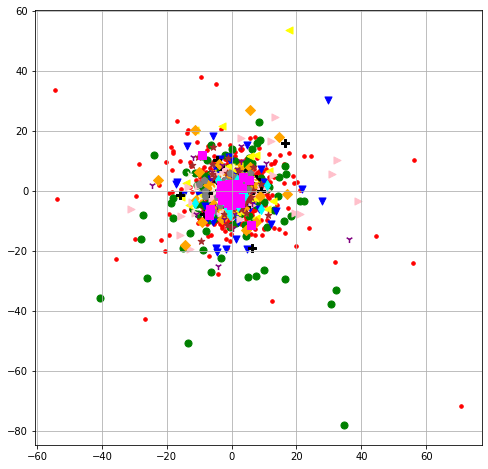

In [12]:
name = os.path.splitext(filename.split(os.sep)[-1])[0]
principal_df, model = perform_experiment_pca(df, title=f"{name} PCA", n_components=2, output_file=f'outputs/{name}.pca.default-params.pdf')
principal_df, model = perform_experiment_tsne(df, title=f"{name} T-SNE", n_components=2, output_file=f'outputs/{name}.t-sne.default-params.pdf')
principal_df, model = perform_experiment_lle(df, title=f"{name} LLE", n_components=2, output_file=f'outputs/{name}.lle.default-params.pdf')
principal_df, model = perform_experiment_mlle(df, title=f"{name} Modified LLE", n_components=2, output_file=f'outputs/{name}.mlle.default-params.pdf')
principal_df, model = perform_experiment_se(df, title=f"{name} Spectral Embeeding", n_components=2, output_file=f'outputs/{name}.se.default-params.pdf')
principal_df, model = perform_experiment_isomap(df, f"{name} ISOMAP", n_components=2, output_file=f'outputs/{name}.isomap.default-params.pdf')
principal_df, model = perform_experiment_mds(df, f"{name} MDS", n_components=2, output_file=f'outputs/{name}.mds.default-params.pdf')

## CodeNetBestSeqsSBLP2021_merge_classes

In [13]:
filename = "data/CodeNetBestSeqsSBLP2021_merge_classes.csv"
df = pd.read_csv(filename)
df.tail()

Unnamed: 0               name  class      0      1    2    3     4    5  \
2495        2495  p02891_s026788939      2  196.0  195.0  0.0  0.0  34.0  0.0   
2496        2496  p03803_s164708696      2  356.0  311.0  0.0  0.0  52.0  0.0   
2497        2497  p03408_s003650092      2   97.0   80.0  0.0  0.0  27.0  0.0   
2498        2498  p03280_s131740813      2  203.0  229.0  0.0  0.0  20.0  0.0   
2499        2499  p02917_s054629196      2    3.0   11.0  0.0  0.0   0.0  0.0   

         6  ...    55   56    57   58   59     60   61    62   63   64  
2495   6.0  ...  57.0  0.0   5.0  2.0  0.0  388.0  0.0  24.0  0.0  0.0  
2496  14.0  ...  97.0  2.0  11.0  0.0  0.0  674.0  0.0  41.0  0.0  0.0  
2497   3.0  ...  19.0  0.0   3.0  0.0  0.0  206.0  0.0  15.0  0.0  0.0  
2498   3.0  ...  69.0  0.0  10.0  0.0  0.0  619.0  0.0  17.0  0.0  0.0  
2499   0.0  ...   3.0  0.0   0.0  0.0  0.0    7.0  0.0   0.0  0.0  0.0  

[5 rows x 68 columns]

Perform manifold took 0.009 seconds!
Figure saved to outputs/CodeNetBestSeqsSBLP2021_merge_classes.pca.default-params.pdf


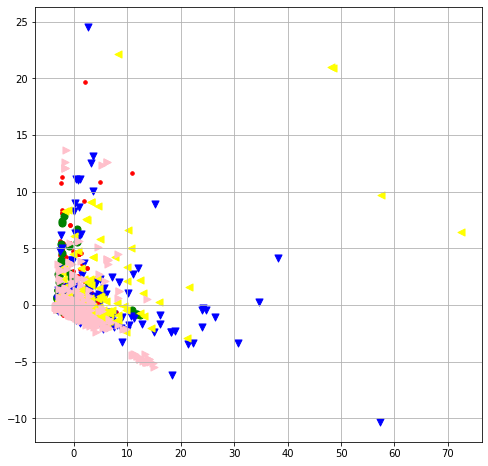

Perform manifold took 6.564 seconds!
Figure saved to outputs/CodeNetBestSeqsSBLP2021_merge_classes.t-sne.default-params.pdf


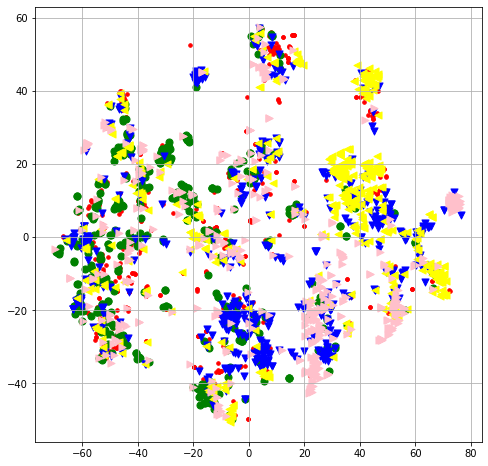

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Perform manifold took 1.327 seconds!
Figure saved to outputs/CodeNetBestSeqsSBLP2021_merge_classes.se.default-params.pdf


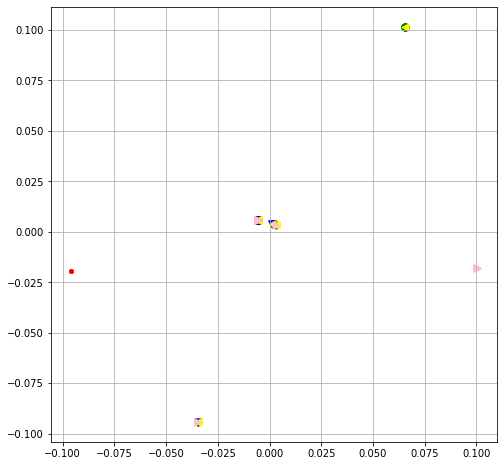

Perform manifold took 2.722 seconds!
Figure saved to outputs/CodeNetBestSeqsSBLP2021_merge_classes.isomap.default-params.pdf


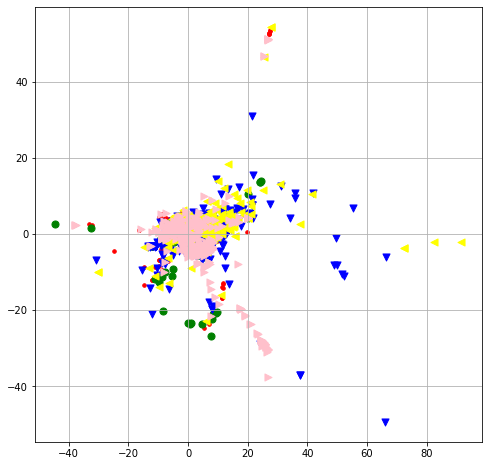

Perform manifold took 143.867 seconds!
Figure saved to outputs/CodeNetBestSeqsSBLP2021_merge_classes.mds.default-params.pdf


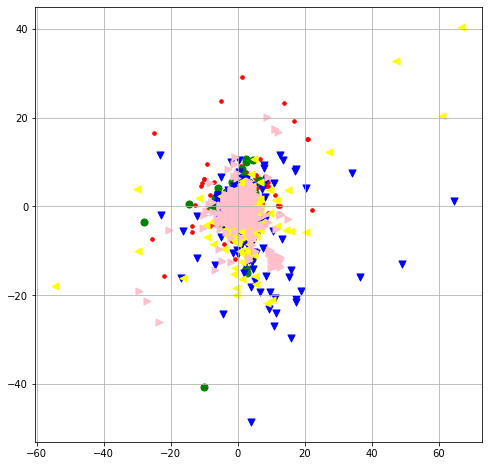

In [14]:
name = os.path.splitext(filename.split(os.sep)[-1])[0]
principal_df, model = perform_experiment_pca(df, title=f"{name} PCA", n_components=2, output_file=f'outputs/{name}.pca.default-params.pdf')
principal_df, model = perform_experiment_tsne(df, title=f"{name} T-SNE", n_components=2, output_file=f'outputs/{name}.t-sne.default-params.pdf')
#principal_df, model = perform_experiment_lle(df, title=f"{name} LLE", n_components=2, output_file=f'outputs/{name}.lle.default-params.pdf')
#principal_df, model = perform_experiment_mlle(df, title=f"{name} Modified LLE", n_components=2, output_file=f'outputs/{name}.mlle.default-params.pdf')
principal_df, model = perform_experiment_se(df, title=f"{name} Spectral Embeeding", n_components=2, output_file=f'outputs/{name}.se.default-params.pdf')
principal_df, model = perform_experiment_isomap(df, f"{name} ISOMAP", n_components=2, output_file=f'outputs/{name}.isomap.default-params.pdf')
principal_df, model = perform_experiment_mds(df, f"{name} MDS", n_components=2, output_file=f'outputs/{name}.mds.default-params.pdf')

## CodeNetBestSeqsSBLP2021

In [15]:
filename = "data/CodeNetBestSeqsSBLP2021.csv"
df = pd.read_csv(filename)
df.tail()

Unnamed: 0        name  class     0      1    2    3     4    5    6  \
2495        2495  s574501869      2  84.0   55.0  0.0  0.0  18.0  0.0  2.0   
2496        2496  s672355252      2  82.0   39.0  0.0  0.0   9.0  0.0  1.0   
2497        2497  s369411689      2  83.0   48.0  0.0  0.0  16.0  0.0  2.0   
2498        2498  s138181654      2  85.0   40.0  0.0  0.0  15.0  0.0  2.0   
2499        2499  s525082001      2  59.0  113.0  0.0  0.0   0.0  0.0  0.0   

      ...    55   56   57   58   59     60   61   62   63   64  
2495  ...  16.0  0.0  2.0  0.0  0.0  150.0  0.0  9.0  0.0  0.0  
2496  ...  12.0  0.0  2.0  0.0  0.0  145.0  0.0  9.0  0.0  0.0  
2497  ...  14.0  0.0  2.0  0.0  0.0  149.0  0.0  9.0  0.0  0.0  
2498  ...  12.0  0.0  2.0  0.0  0.0  143.0  0.0  9.0  0.0  0.0  
2499  ...  29.0  0.0  3.0  0.0  0.0  132.0  0.0  0.0  0.0  0.0  

[5 rows x 68 columns]

Perform manifold took 0.019 seconds!
Figure saved to outputs/CodeNetBestSeqsSBLP2021.pca.default-params.pdf


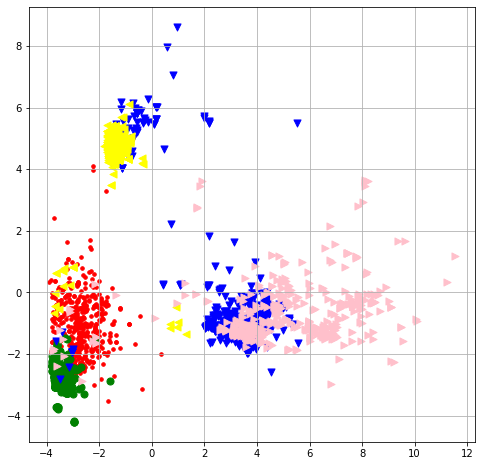

Perform manifold took 5.767 seconds!
Figure saved to outputs/CodeNetBestSeqsSBLP2021.t-sne.default-params.pdf


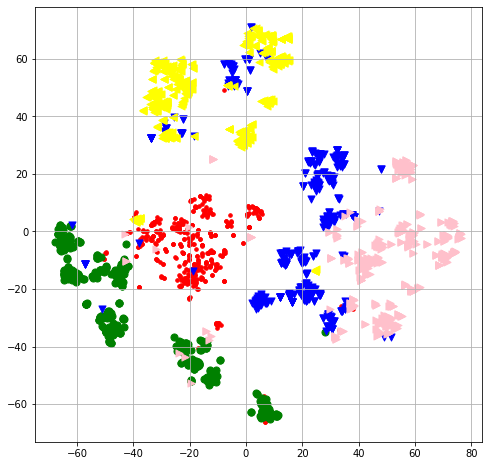

Perform manifold took 0.583 seconds!
Figure saved to outputs/CodeNetBestSeqsSBLP2021.lle.default-params.pdf


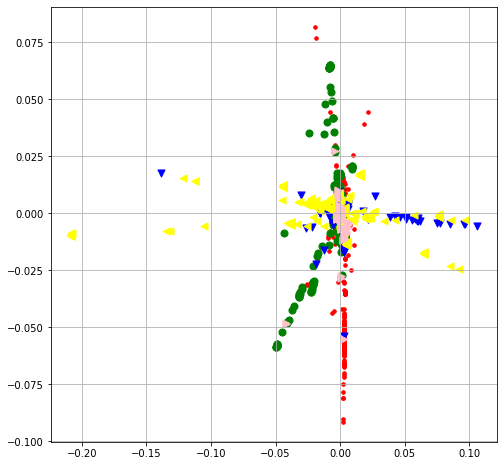

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Perform manifold took 1.995 seconds!
Figure saved to outputs/CodeNetBestSeqsSBLP2021.se.default-params.pdf


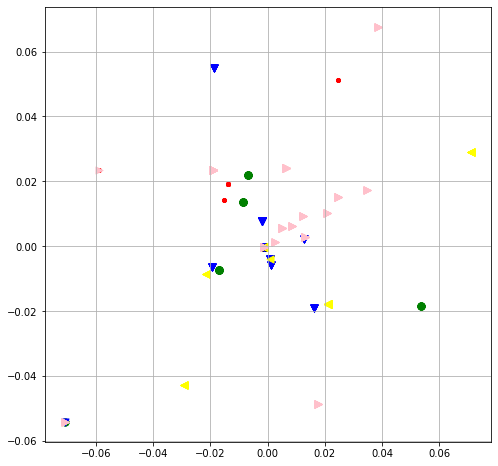

Perform manifold took 1.821 seconds!
Figure saved to outputs/CodeNetBestSeqsSBLP2021.isomap.default-params.pdf


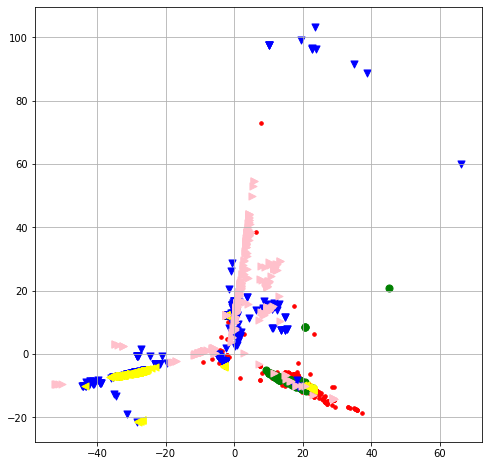

Perform manifold took 143.726 seconds!
Figure saved to outputs/CodeNetBestSeqsSBLP2021.mds.default-params.pdf


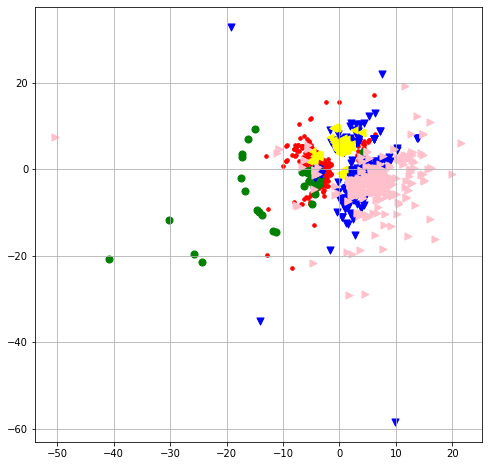

In [16]:
name = os.path.splitext(filename.split(os.sep)[-1])[0]
principal_df, model = perform_experiment_pca(df, title=f"{name} PCA", n_components=2, output_file=f'outputs/{name}.pca.default-params.pdf')
principal_df, model = perform_experiment_tsne(df, title=f"{name} T-SNE", n_components=2, output_file=f'outputs/{name}.t-sne.default-params.pdf')
principal_df, model = perform_experiment_lle(df, title=f"{name} LLE", n_components=2, output_file=f'outputs/{name}.lle.default-params.pdf')
#principal_df, model = perform_experiment_mlle(df, title=f"{name} Modified LLE", n_components=2, output_file=f'outputs/{name}.mlle.default-params.pdf')
principal_df, model = perform_experiment_se(df, title=f"{name} Spectral Embeeding", n_components=2, output_file=f'outputs/{name}.se.default-params.pdf')
principal_df, model = perform_experiment_isomap(df, f"{name} ISOMAP", n_components=2, output_file=f'outputs/{name}.isomap.default-params.pdf')
principal_df, model = perform_experiment_mds(df, f"{name} MDS", n_components=2, output_file=f'outputs/{name}.mds.default-params.pdf')

## PCA With POJ-5

In [17]:
filename = "data/POJ-5.csv"
df = pd.read_csv(filename)
df.tail()

Unnamed: 0  name  class    0     1    2    3    4    5    6  ...    55  \
2495        2495   738      2  1.0  34.0  0.0  0.0  0.0  0.0  0.0  ...  14.0   
2496        2496   568      2  1.0  27.0  0.0  0.0  0.0  0.0  0.0  ...  13.0   
2497        2497   742      2  1.0  25.0  0.0  0.0  0.0  0.0  0.0  ...  12.0   
2498        2498   455      2  1.0  28.0  0.0  0.0  0.0  0.0  0.0  ...  12.0   
2499        2499    63      2  1.0  28.0  0.0  0.0  0.0  0.0  0.0  ...   8.0   

       56   57   58   59    60   61   62   63   64  
2495  2.0  0.0  0.0  0.0   4.0  0.0  0.0  0.0  0.0  
2496  1.0  0.0  0.0  0.0   9.0  0.0  0.0  0.0  0.0  
2497  1.0  0.0  0.0  0.0  11.0  0.0  0.0  0.0  0.0  
2498  2.0  0.0  0.0  0.0  10.0  0.0  0.0  0.0  0.0  
2499  1.0  0.0  0.0  0.0   9.0  0.0  0.0  0.0  0.0  

[5 rows x 68 columns]

Perform manifold took 0.006 seconds!
Figure saved to outputs/POJ-5.pca.default-params.pdf


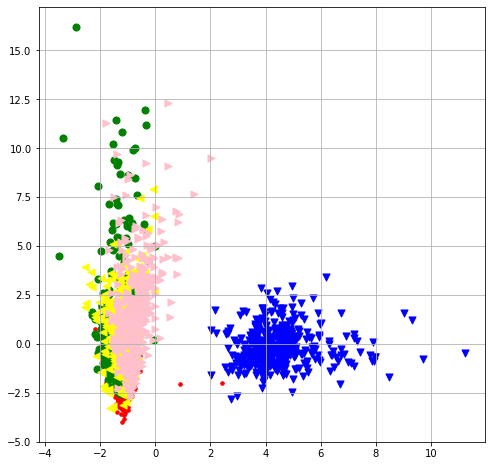

Perform manifold took 5.940 seconds!
Figure saved to outputs/POJ-5.t-sne.default-params.pdf


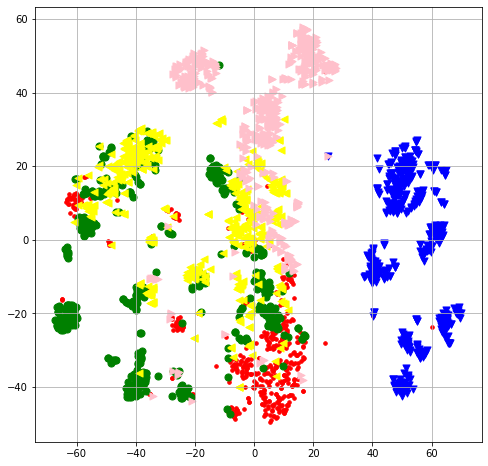

Perform manifold took 0.675 seconds!
Figure saved to outputs/POJ-5.lle.default-params.pdf


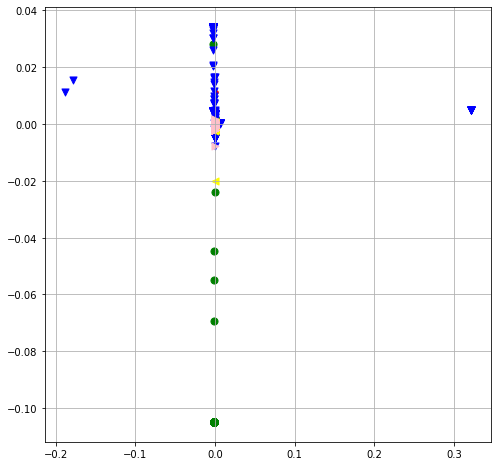

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_locally_linear.py:449: RuntimeWarning: invalid value encountered in double_scalars
  alpha_i = np.linalg.norm(Vi.sum(0)) / np.sqrt(s_i)


Perform manifold took 0.880 seconds!
Figure saved to outputs/POJ-5.mlle.default-params.pdf


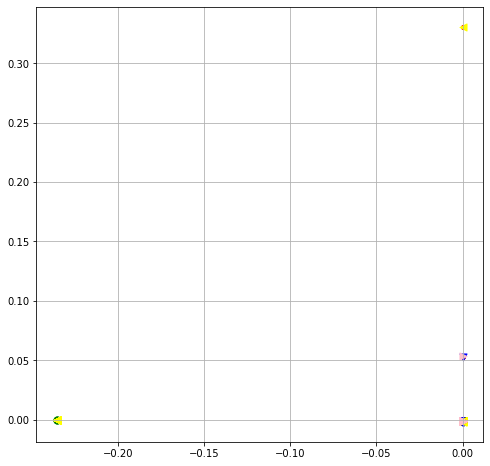

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Perform manifold took 1.102 seconds!
Figure saved to outputs/POJ-5.se.default-params.pdf


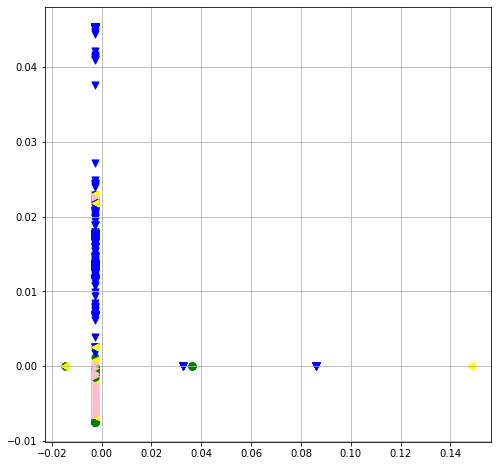

Perform manifold took 2.498 seconds!
Figure saved to outputs/POJ-5.isomap.default-params.pdf


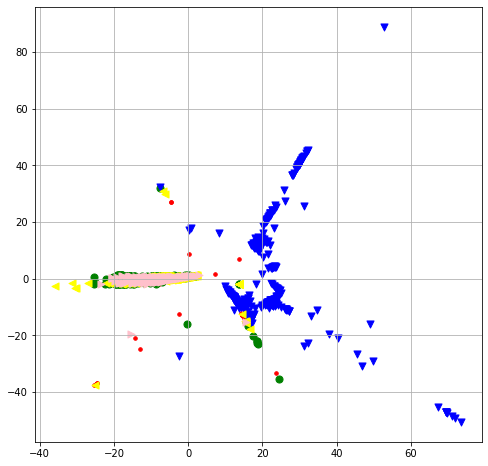

Perform manifold took 143.065 seconds!
Figure saved to outputs/POJ-5.mds.default-params.pdf


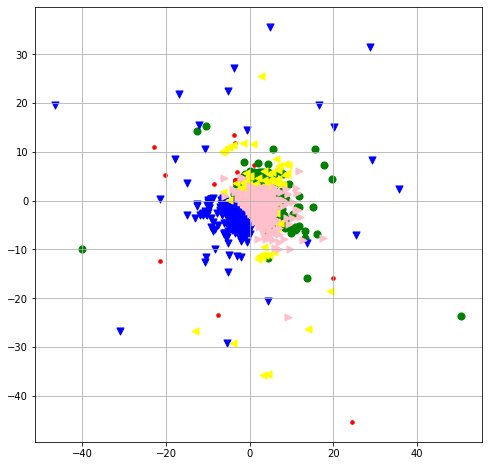

In [19]:
name = os.path.splitext(filename.split(os.sep)[-1])[0]
principal_df, model = perform_experiment_pca(df, title=f"{name} PCA", n_components=2, output_file=f'outputs/{name}.pca.default-params.pdf')
principal_df, model = perform_experiment_tsne(df, title=f"{name} T-SNE", n_components=2, output_file=f'outputs/{name}.t-sne.default-params.pdf')
principal_df, model = perform_experiment_lle(df, title=f"{name} LLE", n_components=2, output_file=f'outputs/{name}.lle.default-params.pdf')
principal_df, model = perform_experiment_mlle(df, title=f"{name} Modified LLE", n_components=2, output_file=f'outputs/{name}.mlle.default-params.pdf')
principal_df, model = perform_experiment_se(df, title=f"{name} Spectral Embeeding", n_components=2, output_file=f'outputs/{name}.se.default-params.pdf')
principal_df, model = perform_experiment_isomap(df, f"{name} ISOMAP", n_components=2, output_file=f'outputs/{name}.isomap.default-params.pdf')
principal_df, model = perform_experiment_mds(df, f"{name} MDS", n_components=2, output_file=f'outputs/{name}.mds.default-params.pdf')

## POJBestSeqsSBLP2021_merge_2classes

In [20]:
filename = "data/POJBestSeqsSBLP2021_merge_2classes.csv"
df = pd.read_csv(filename)
df.tail()

Unnamed: 0     name  class    0     1    2    3    4    5    6  ...  \
1495        1495  38_1810      2  1.0  20.0  0.0  0.0  0.0  0.0  0.0  ...   
1496        1496  38_1421      2  1.0  24.0  0.0  0.0  0.0  0.0  0.0  ...   
1497        1497  54_1233      2  3.0  29.0  0.0  0.0  0.0  0.0  0.0  ...   
1498        1498  38_1978      2  2.0  20.0  0.0  0.0  0.0  0.0  0.0  ...   
1499        1499  38_1685      2  1.0  46.0  0.0  0.0  0.0  0.0  0.0  ...   

        55   56   57   58   59    60   61   62   63   64  
1495  11.0  0.0  0.0  0.0  0.0   3.0  0.0  0.0  0.0  0.0  
1496  12.0  0.0  0.0  0.0  0.0   3.0  0.0  0.0  0.0  0.0  
1497  10.0  0.0  0.0  0.0  0.0  11.0  0.0  0.0  0.0  0.0  
1498  11.0  0.0  0.0  0.0  0.0   4.0  0.0  0.0  0.0  0.0  
1499  24.0  0.0  1.0  0.0  0.0   6.0  0.0  0.0  0.0  0.0  

[5 rows x 68 columns]

Perform manifold took 0.004 seconds!
Figure saved to outputs/POJBestSeqsSBLP2021_merge_2classes.pca.default-params.pdf


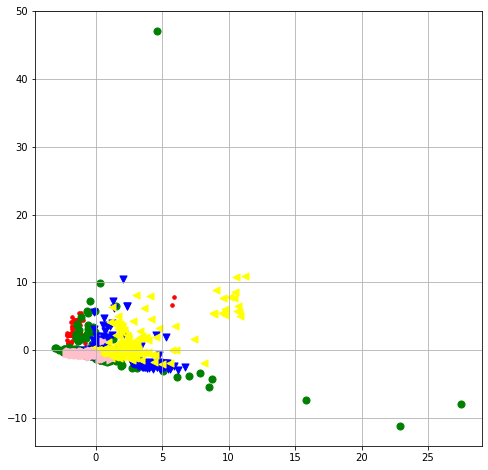

Perform manifold took 3.292 seconds!
Figure saved to outputs/POJBestSeqsSBLP2021_merge_2classes.t-sne.default-params.pdf


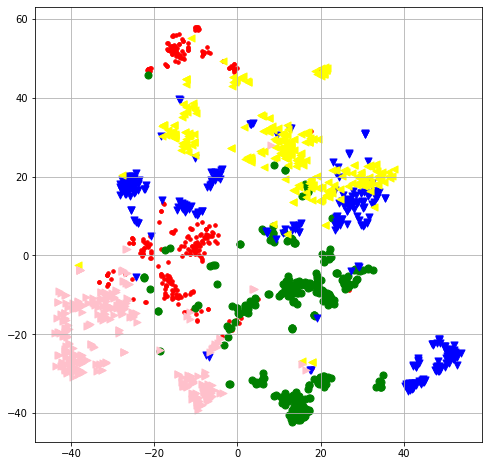

Perform manifold took 0.338 seconds!
Figure saved to outputs/POJBestSeqsSBLP2021_merge_2classes.lle.default-params.pdf


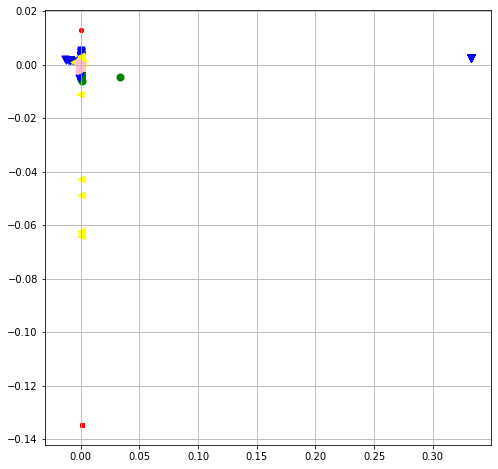

Perform manifold took 0.421 seconds!
Figure saved to outputs/POJBestSeqsSBLP2021_merge_2classes.mlle.default-params.pdf


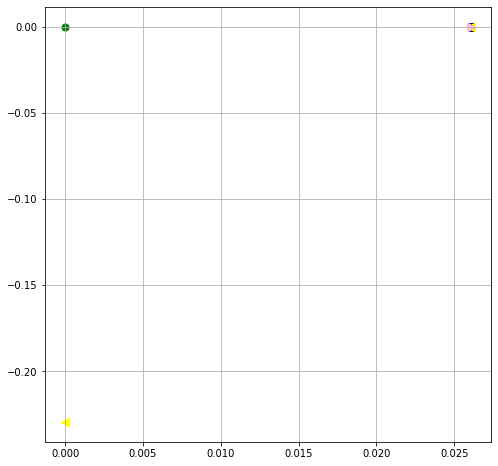

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Perform manifold took 0.703 seconds!
Figure saved to outputs/POJBestSeqsSBLP2021_merge_2classes.se.default-params.pdf


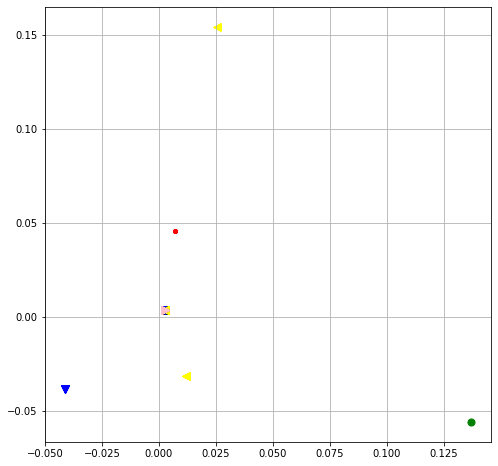

Perform manifold took 0.819 seconds!
Figure saved to outputs/POJBestSeqsSBLP2021_merge_2classes.isomap.default-params.pdf


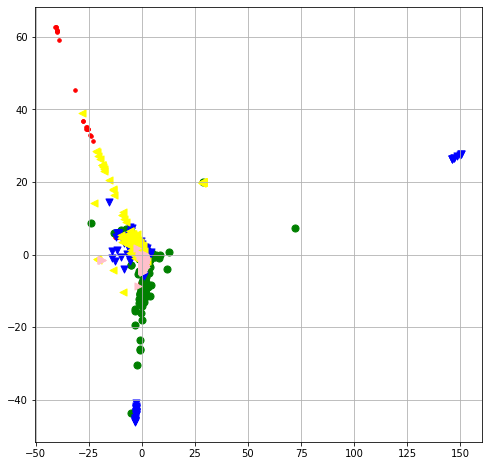

Perform manifold took 44.866 seconds!
Figure saved to outputs/POJBestSeqsSBLP2021_merge_2classes.mds.default-params.pdf


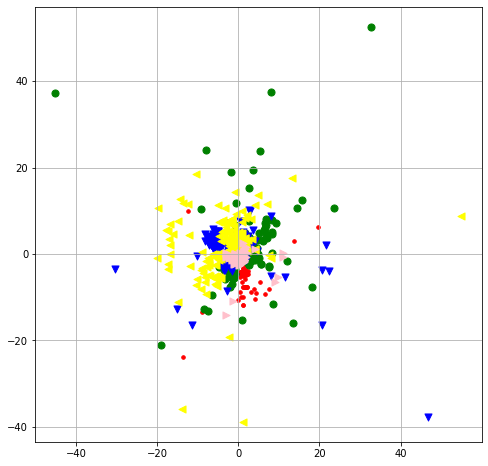

In [21]:
name = os.path.splitext(filename.split(os.sep)[-1])[0]
principal_df, model = perform_experiment_pca(df, title=f"{name} PCA", n_components=2, output_file=f'outputs/{name}.pca.default-params.pdf')
principal_df, model = perform_experiment_tsne(df, title=f"{name} T-SNE", n_components=2, output_file=f'outputs/{name}.t-sne.default-params.pdf')
principal_df, model = perform_experiment_lle(df, title=f"{name} LLE", n_components=2, output_file=f'outputs/{name}.lle.default-params.pdf')
principal_df, model = perform_experiment_mlle(df, title=f"{name} Modified LLE", n_components=2, output_file=f'outputs/{name}.mlle.default-params.pdf')
principal_df, model = perform_experiment_se(df, title=f"{name} Spectral Embeeding", n_components=2, output_file=f'outputs/{name}.se.default-params.pdf')
principal_df, model = perform_experiment_isomap(df, f"{name} ISOMAP", n_components=2, output_file=f'outputs/{name}.isomap.default-params.pdf')
principal_df, model = perform_experiment_mds(df, f"{name} MDS", n_components=2, output_file=f'outputs/{name}.mds.default-params.pdf')

## POJBestSeqsSBLP2021_merge_Nclasses

In [22]:
filename = "data/POJBestSeqsSBLP2021_merge_Nclasses.csv"
df = pd.read_csv(filename)
df.tail()

Unnamed: 0     name  class    0     1    2    3    4    5    6  ...  \
1820        1820  36_1555      2  3.0  19.0  0.0  0.0  0.0  0.0  0.0  ...   
1821        1821   85_205      2  1.0  15.0  0.0  0.0  0.0  0.0  0.0  ...   
1822        1822  85_1572      2  1.0  24.0  0.0  0.0  0.0  0.0  0.0  ...   
1823        1823   24_359      2  4.0  20.0  0.0  0.0  0.0  0.0  0.0  ...   
1824        1824  27_1318      2  1.0  13.0  0.0  0.0  0.0  0.0  0.0  ...   

       55   56   57   58   59    60   61   62   63   64  
1820  7.0  0.0  0.0  0.0  0.0  10.0  0.0  0.0  0.0  0.0  
1821  5.0  0.0  0.0  0.0  0.0   5.0  0.0  0.0  0.0  0.0  
1822  9.0  0.0  0.0  0.0  0.0   8.0  0.0  0.0  0.0  0.0  
1823  6.0  0.0  0.0  0.0  0.0   6.0  0.0  0.0  0.0  0.0  
1824  5.0  0.0  0.0  0.0  0.0   4.0  0.0  0.0  0.0  0.0  

[5 rows x 68 columns]

Perform manifold took 0.005 seconds!
Figure saved to outputs/POJBestSeqsSBLP2021_merge_Nclasses.pca.default-params.pdf


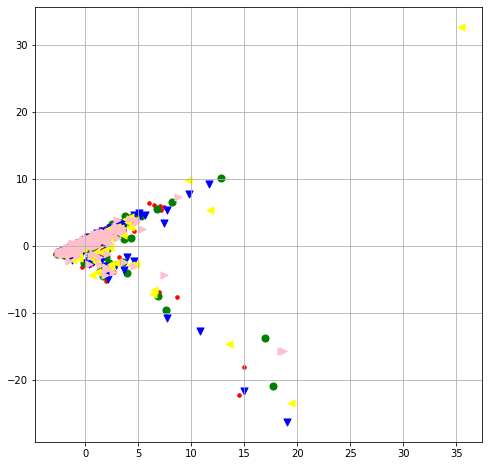

Perform manifold took 4.203 seconds!
Figure saved to outputs/POJBestSeqsSBLP2021_merge_Nclasses.t-sne.default-params.pdf


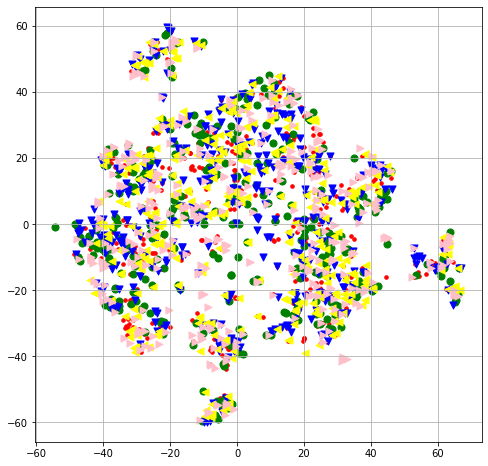

Perform manifold took 0.666 seconds!
Figure saved to outputs/POJBestSeqsSBLP2021_merge_Nclasses.lle.default-params.pdf


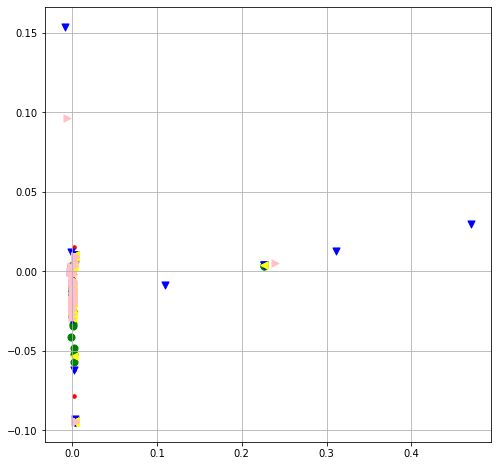

Perform manifold took 0.759 seconds!
Figure saved to outputs/POJBestSeqsSBLP2021_merge_Nclasses.mlle.default-params.pdf


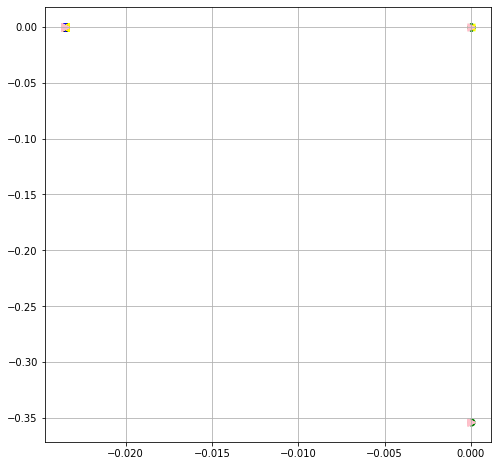

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Perform manifold took 0.807 seconds!
Figure saved to outputs/POJBestSeqsSBLP2021_merge_Nclasses.se.default-params.pdf


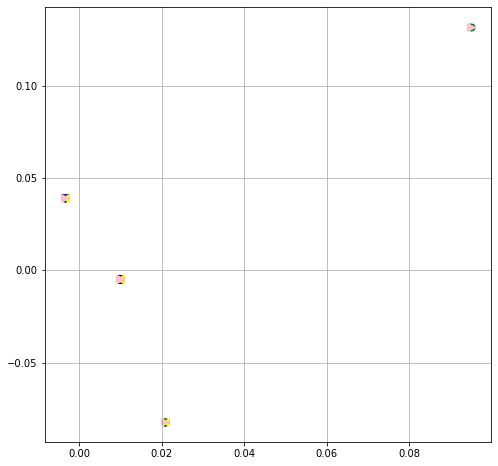

Perform manifold took 1.456 seconds!
Figure saved to outputs/POJBestSeqsSBLP2021_merge_Nclasses.isomap.default-params.pdf


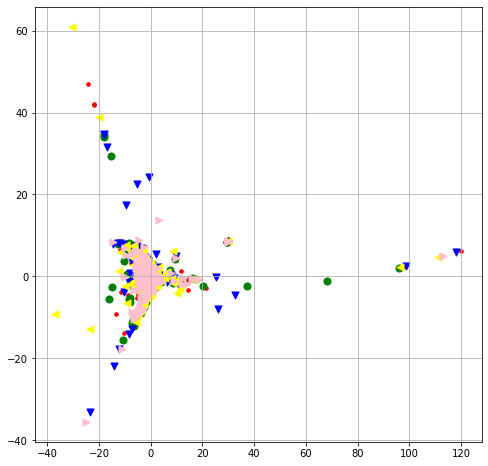

Perform manifold took 67.380 seconds!
Figure saved to outputs/POJBestSeqsSBLP2021_merge_Nclasses.mds.default-params.pdf


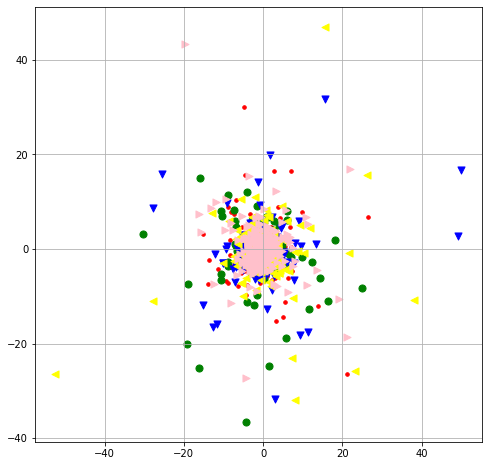

In [23]:
name = os.path.splitext(filename.split(os.sep)[-1])[0]
principal_df, model = perform_experiment_pca(df, title=f"{name} PCA", n_components=2, output_file=f'outputs/{name}.pca.default-params.pdf')
principal_df, model = perform_experiment_tsne(df, title=f"{name} T-SNE", n_components=2, output_file=f'outputs/{name}.t-sne.default-params.pdf')
principal_df, model = perform_experiment_lle(df, title=f"{name} LLE", n_components=2, output_file=f'outputs/{name}.lle.default-params.pdf')
principal_df, model = perform_experiment_mlle(df, title=f"{name} Modified LLE", n_components=2, output_file=f'outputs/{name}.mlle.default-params.pdf')
principal_df, model = perform_experiment_se(df, title=f"{name} Spectral Embeeding", n_components=2, output_file=f'outputs/{name}.se.default-params.pdf')
principal_df, model = perform_experiment_isomap(df, f"{name} ISOMAP", n_components=2, output_file=f'outputs/{name}.isomap.default-params.pdf')
principal_df, model = perform_experiment_mds(df, f"{name} MDS", n_components=2, output_file=f'outputs/{name}.mds.default-params.pdf')